In [20]:
%load_ext autoreload
%autoreload 2
import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import sandbox_correct as sb
import importlib
importlib.reload(sb)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'sandbox_correct' from '/home/saha/Desktop/tesis/colera/polaron_revisited/sandbox_correct.py'>

In [168]:
save_dir = "./saved_dynamics1"
filepath = save_dir + "/eff_coupling_6.0MHz_20251102_024545.pkl"

dynamics, parameters = sb.load_full_dynamics(filepath)

N = parameters['N']
cavity_diss_rate = parameters['cavity_diss_rate']
input_power = parameters['input_power']
rabi_freq = parameters['rabi_freq']
eff_coupling = parameters['eff_coupling']
qubit_targetz = parameters['qubit_targetz']
norm = parameters['norm']
final_time__mus = parameters['final_time__mus'] 
time_steps = parameters["time_steps"]
psi0_atom = parameters['initial_state_qubit']
tlist = np.linspace(0, final_time__mus, time_steps)

cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 


Multi-dynamics loaded from: ./saved_dynamics1/eff_coupling_6.0MHz_20251102_024545.pkl
Description: Multi-dynamics for eff_coupling=6MHz
Timestamp: 20251102_024545


In [169]:
diag_freq = (rabi_freq**2 + (cavity_detuning+eff_coupling)**2)**.5

In [170]:
x_exp = expect(sx, dynamics)
z_exp = expect(sz, dynamics)
photon_number = expect(d.dag()*d, dynamics)

#compare with target hamiltonian expecation values:

H_qubit = sb.target_hamiltonian(parameters)
evalues_target, estates_target = H_qubit.eigenstates()
# For ground state
gs_sigmax = expect(sigmax(), estates_target[0])
gs_sigmaz = expect(sigmaz(), estates_target[0])

# For excited state
es_sigmax = expect(sigmax(), estates_target[1])
es_sigmaz = expect(sigmaz(), estates_target[1])

# Non-polaron cavity state
cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

# Get cavity dynamics by tracing out qubit
cavity_dynamics = np.array([ptrace(i, 0) for i in dynamics])

# Fidelity with non-polaron cavity state
non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

# Calculate the other two cavity fields
cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

rho_cavity_e_t = np.array([sb.coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, 
                        cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist/1e-6])
rho_cavity_g_t = np.array([sb.coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, 
                        cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist/1e-6])



# Calculate fidelities with these states
fidelity_e = np.array([fidelity(rho_cavity_e_t[i], cavity_dynamics[i]) for i in np.arange(len(tlist))])
fidelity_e = np.array([fidelity(rho_cavity_g_t[i], cavity_dynamics[i]) for i in np.arange(len(tlist))])


# Calculate qubit populations
rho_qubit = np.array([ptrace(i, 1) for i in dynamics])
P_g = np.array([i[0,0] for i in rho_qubit]) 
P_e = np.array([i[1,1] for i in rho_qubit])
C_eg =  np.array([i[0,1] for i in rho_qubit])
C_ge =  np.array([i[1,0] for i in rho_qubit])


cavity_e_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])

coherent_e_t = [coherent(N, i) for i in cavity_e_t]
coherent_g_t = [coherent(N, i) for i in cavity_g_t]

term_eg_t = np.array([C_ge[i]*coherent_e_t[i]*coherent_g_t[i].dag() for i in range(len(tlist))])
term_ge_t = np.array([C_eg[i]*coherent_g_t[i]*coherent_e_t[i].dag() for i in range(len(tlist))])


cavity_field_superposition_diag = np.array([P_e[i] * rho_cavity_e_t[i] + P_g[i] * rho_cavity_g_t[i] for i in range(len(tlist))])
cavity_field_superposition = np.array([cavity_field_superposition_diag[i] + term_eg_t[i] + term_ge_t[i] for i in range(len(tlist))])
cavity_field_superposition = np.array([P_g[i] * rho_cavity_g_t[i] + P_e[i] * rho_cavity_e_t[i] for i in range(len(tlist))])
cavity_field_superposition = np.array([P_g[i] * coherent_g_t[i] + P_e[i] * coherent_e_t[i] for i in range(len(tlist))])

photon_number_superposition= np.array([expect(destroy(N).dag()*destroy(N), i) for i in cavity_field_superposition])


displace_e_t = [displace(N, i) for i in cavity_e_t]
displace_g_t = [displace(N, i) for i in cavity_g_t]
projector_e = basis(2,0)*basis(2,0).dag()
projector_g = basis(2,1)*basis(2,1).dag()

polaron_trafo = [tensor(displace_e_t[i],projector_e) + tensor(displace_g_t[i],projector_g) for i in range(len(tlist))]




dynamics_polaron_frame = [polaron_trafo[i].dag()*dynamics[i]*polaron_trafo[i] for i in range(len(tlist))]

displace_np = tensor(displace(N, cavity_field),qeye(2))
dynamics_normal_displace = [displace_np.dag()*i*displace_np for i in dynamics]

x_exp_polaron = expect(sx, dynamics_polaron_frame)
z_exp_polaron = expect(sz, dynamics_polaron_frame)
photon_number_polaron = expect(d.dag()*d, dynamics_polaron_frame)



In [180]:
cavity_m_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling*(rabi_freq/diag_freq), cavity_diss_rate, N) for i in tlist*1e-6])
cavity_p_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling*(rabi_freq/diag_freq), cavity_diss_rate, N) for i in tlist*1e-6])
displace_m_t = [displace(N, i) for i in cavity_m_t]
displace_p_t = [displace(N, i) for i in cavity_p_t]
sx_plus = (basis(2,0) + basis(2,1))/2**.5
sx_minus = (basis(2,0) - basis(2,1))/2**.5
projector_plus = sx_plus*sx_plus.dag()
projector_minus = sx_minus*sx_minus.dag()
polaron_trafo2 = [tensor(displace_p_t[i],projector_plus) + tensor(displace_m_t[i],projector_minus) + tensor(displace_e_t[i],projector_e) + tensor(displace_g_t[i],projector_g)for i in range(len(tlist))]

dynamics_polaron_frame2 = [polaron_trafo2[i].dag()*dynamics[i]*polaron_trafo2[i] for i in range(len(tlist))]

x_exp_polaron2 = expect(sx, dynamics_polaron_frame2)
z_exp_polaron2 = expect(sz, dynamics_polaron_frame2)
photon_number_polaron2 = expect(d.dag()*d, dynamics_polaron_frame2)


In [172]:
(rho_qubit[-1]*rho_qubit[-1]).tr()

0.9002375189788199

In [173]:
def target_hamiltonian_polaron(parameters):

    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']

    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number+ 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5

    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)

    #Calculate the other two cavity fields
    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    naive_polaron_shift = 2*eff_coupling*np.real(cavity_field_g*np.conj(cavity_field_e))

    qubit_detuning_lamb_shift_pol = qubit_detuning + eff_coupling*(2*np.real(cavity_field_g*np.conj(cavity_field_e))+ 1)

    rabi_freq__N = rabi_freq/norm
    qubit_detuning_lamb_shift_pol__N = qubit_detuning_lamb_shift_pol/norm

    print(qubit_detuning_lamb_shift_pol__N, rabi_freq__N)

    H_qubit_target = .5*(qubit_detuning_lamb_shift_pol__N*sigmaz() + rabi_freq__N*sigmax())
    return H_qubit_target


H_qubit_pol = target_hamiltonian_polaron(parameters)
evalues_target_pol, estates_target_pol = H_qubit_pol.eigenstates()


# For ground state
gs_sigmax_pol = expect(sigmax(), estates_target_pol[0])
gs_sigmaz_pol = expect(sigmaz(), estates_target_pol[0])

# For excited state
es_sigmax_pol = expect(sigmax(), estates_target_pol[1])
es_sigmaz_pol = expect(sigmaz(), estates_target_pol[1])

0.18462009976401922 3.3333333333333335


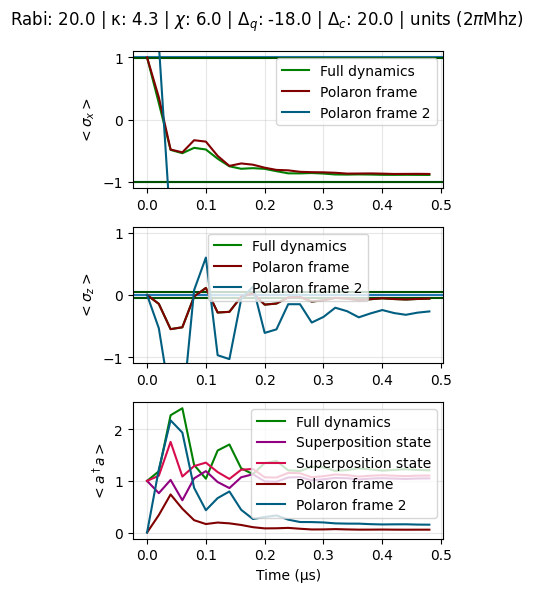

In [181]:
# Generate plot
max_time = 0.5
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp[time_mask], color='#008000', label='Full dynamics')
axes[1].plot(tlist_plot, z_exp[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000', label='Full dynamics')

#compare with target hamiltonian expecation values:
axes[0].axhline(gs_sigmax)
axes[0].axhline(es_sigmax)
axes[1].axhline(gs_sigmaz)
axes[1].axhline(es_sigmaz)

axes[0].axhline(gs_sigmax_pol, color='#005000')
axes[0].axhline(es_sigmax_pol, color='#005000')
axes[1].axhline(gs_sigmaz_pol, color='#005000')
axes[1].axhline(es_sigmaz_pol, color='#005000')


axes[2].plot(tlist_plot, photon_number_superposition[time_mask], color='#900080', label='Superposition state')
axes[2].plot(tlist_plot, photon_number_superposition[time_mask]+photon_number_polaron[time_mask], color="#D60D4D", label='Superposition state')

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_polaron[time_mask], color='#800000', label='Polaron frame')
axes[1].plot(tlist_plot, z_exp_polaron[time_mask], color='#800000', label='Polaron frame')
axes[2].plot(tlist_plot, photon_number_polaron[time_mask], color='#800000', label='Polaron frame')

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_polaron2[time_mask], color="#005E80", label='Polaron frame 2')
axes[1].plot(tlist_plot, z_exp_polaron2[time_mask], color="#005E80", label='Polaron frame 2')
axes[2].plot(tlist_plot, photon_number_polaron2[time_mask], color="#005E80", label='Polaron frame 2')


    # Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")

params_text.append(r"units (2$\pi$Mhz)")

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()


In [ ]:
final_time__mus = 0.5
parameters['final_time__mus'] = final_time__mus

dynamics = sb.calculate_full_dynamics_polaron(parameters)

x_exp = expect(sx, dynamics)
z_exp = expect(sz, dynamics)
photon_number = expect(d.dag()*d, dynamics)

tlist = tlist = np.linspace(0, final_time__mus, time_steps)


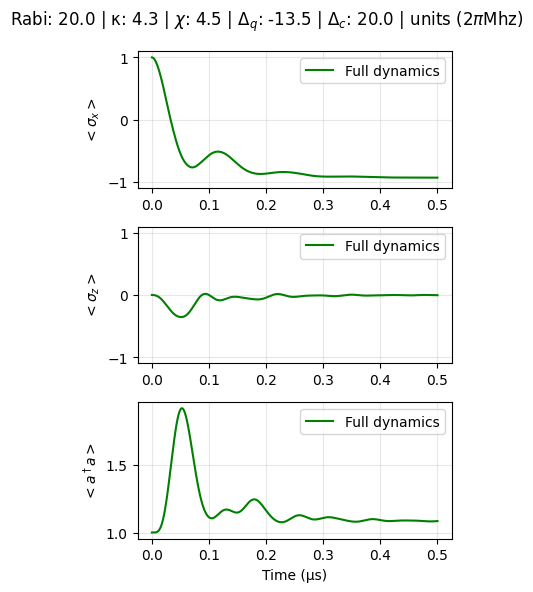

In [150]:
# Generate plot
max_time = None
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp[time_mask], color='#008000', label='Full dynamics')
axes[1].plot(tlist_plot, z_exp[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000', label='Full dynamics')




# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")

params_text.append(r"units (2$\pi$Mhz)")

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()